In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision.datasets import ImageFolder
import os
import cv2
from tqdm import tqdm
import numpy as np
import time

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
import ntpath


In [4]:
(os.listdir(r"/home/tk/jnotebook/AI/Akciger/Mixed/train/TURBERCULOSIS/"))[5]

'Tuberculosis-454.png'

## DATASETS

PPDataset, takes list of images but does not upload it directly. it process the image while trying to get it by path. Avoids out of memory problem if there is a lot of image.

In [10]:

class PPDataset(Dataset):
    def __init__(
        self,
        image_size=150,
        data_transforms = transforms.Compose([
            transforms.RandomRotation(30),  # Randomly rotate images
            transforms.RandomResizedCrop(150, scale=(0.8, 1.0)),  # Randomly crop and resize
            transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
            transforms.ToTensor(),  # Convert the image to a tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale images
        ])
        ):
        self.list=[]
        self.image_size=image_size
        self.transform=data_transforms
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.read_transform = transforms.Compose([
            transforms.ToTensor(),  # Convert the image to a tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale images
        ])
        return

    def add_data(self,path,label_name,multiply=1):
        
        index = self.name_to_index(label_name)
        if index == -1: # NOT EXİST
            path_file = []
            for p in os.listdir(path):
                path_file.append(os.path.join(path,p))
            self.list.append({"name":label_name.strip().lower(),"data":path_file,"enable":True,"multiply":multiply})
        else:           # EXIST
            self.list[index]["multiply"]=multiply
            for path_add in os.listdir(path):
                contains=False
                add_name=ntpath.basename(path_add)
                #print(add_name,path_add)
                for path_list in self.list[index]["data"]:
                    list_name = ntpath.basename(path_list)
                    #print(list_name,path_list)
                    #time.sleep(0.5)
                    if(list_name == add_name):
                        contains=True
                        break
                if not contains:
                    self.list[index]["data"].append(os.path.join(path,path_add))
                    #print(os.path.join(path,path_add))
        #print(self.list[index]["data"])
            #self.list[index]["data"].append(os.listdir(path))

    def __len__(self):
        total_size=0
        for data in self.list:
            if data["enable"]:
                 total_size+=len(data["data"])*data["multiply"]
        return total_size

    def __getitem__(self, index):
        total_size=0
        data_id=0
        for data in self.list:
            if data["enable"]:
                current_size=len(data["data"])
                if index<total_size+current_size*data["multiply"]:
                    index-=total_size
                    path=data["data"][index%current_size]#path=os.path.join(data["path"],data["data"][index])
                    #print(path)
                    #img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    #print(path)
                    image = Image.open(path).convert('L') 
                    
                    image = np.array(image)
                    
                    image = cv2.resize( image, (self.image_size, self.image_size))
                    image = Image.fromarray((image * 255).astype(np.uint8), mode='L')  # Convert to grayscale
                    if self.transform:
                        image = self.transform(image)
    
                    
                    tensor = torch.zeros(self.get_label_size(), dtype=torch.float32).to(self.device)
                    tensor[data_id] = 1
    
                    
                    return image.to(self.device), tensor   #torch.tensor(data_id).to(self.device)
                    #return data["data"][index],data_id
                else:
                    total_size+=current_size*data["multiply"]
                    data_id+=1
            else:
                data_id+=1
        return (None,None)

    def read_and_transform(self,path):
        image = Image.open(path).convert('L') 
        print(path, image==None)
        image = np.array(image)
                    
        image = cv2.resize( image, (self.image_size, self.image_size))
        image = Image.fromarray((image * 255).astype(np.uint8), mode='L')  # Convert to grayscale
                    
        image = self.read_transform(image).to(device)
        return image

    def name_to_index(self,name):
        index = 0
        for data in self.list:
            if data["name"] == name.strip().lower():
                return index
            else:
                index+=1
        return-1

    def index_to_name(self,index):
        if len(self.list)>index:
            return self.list[index]["name"]
        return "N/A"

    def get_label_size(self):
        return len(self.list)
        
    
    def get_data_size_by_name(self,name):
        index = self.name_to_index(name)
        if index==-1:
            return None
        else:
            return len(self.list[index]["data"])

    def __get_info_str__(self):
        str = f"Total Labels: {len(self.list)}\n----------------\nLabels & Size:\n"
        total_size=0
        for i in range(len(self.list)):
            str+=f" ~{self.list[i]["name"]}:{len(self.list[i]["data"])} M:{self.list[i]["multiply"]} E:{(self.list[i]["enable"])} Start Index:{total_size}\n"
            total_size+=len(self.list[i]["data"])*self.list[i]["multiply"]
        str+=f"Total Size:{total_size}"
        return str

    def print_info(self):
        print(self.__get_info_str__())

    def get_label_names(self):
        names=[]
        for n in self.list:
            names.append(n["name"])
        return names

    def enable_all(self):
        for data in self.list:
            data["enable"]=True

    def enable_data(self,label_name,enable=True):
        if type(label_name) is str:
            label_name=self.name_to_index(label_name)
        if label_name!=-1:
            self.list[label_name]["enable"]=True

    def enable_only(self,label_name,enable=True):
        if type(label_name) is str:
            label_name=self.name_to_index(label_name)
        
        for i in range(len(self.list)):
            self.list[i]["enable"] = (i == label_name)

    def change_label_multiply(self,label_name,multiply:int=1):
        if type(label_name) is str:
            label_name=self.name_to_index(label_name)
        if label_name!=-1:
            self.list[label_name]["multiply"]=multiply
        
        
        # Optional: You can apply transformations here (like normalization, augmentation, etc.)

In [11]:
data_train = PPDataset()
data_train.add_data("/home/tk/jnotebook/AI/Akciger/Mixed/train/NORMAL/","normal")
data_train.add_data("/home/tk/jnotebook/AI/Akciger/data/Tuberkuloz/train/Normal/","normal")
data_train.add_data("/home/tk/jnotebook/AI/Akciger/data/pnomoni2/Normal/","normal")
data_train.add_data("/home/tk/jnotebook/AI/Akciger/data/Fibroz/Normal/","normal")
data_train.add_data("/home/tk/jnotebook/AI/Akciger/data/Cancer/Normal cases/","normal")

data_train.add_data("/home/tk/jnotebook/AI/Akciger/Mixed/train/TURBERCULOSIS/","tüberküloz")
data_train.add_data("/home/tk/jnotebook/AI/Akciger/data/Tuberkuloz/train/Tuberculosis/","tüberküloz")

data_train.add_data("/home/tk/jnotebook/AI/Akciger/Mixed/train/PNEUMONIA/","pneumonia")
data_train.add_data("/home/tk/jnotebook/AI/Akciger/data/pnomoni2/Viral Pneumonia/","pneumonia")
data_train.add_data("/home/tk/jnotebook/AI/Akciger/data/Fibroz/Pneumonia/","pneumonia")

data_train.add_data("/home/tk/jnotebook/AI/Akciger/Mixed/train/COVID19/","covid")
data_train.add_data("/home/tk/jnotebook/AI/Akciger/data/Tuberkuloz/train/Covid19/","covid")

data_train.add_data("/home/tk/jnotebook/AI/Akciger/data/Fibroz/Fibrosis/","fibroz",multiply=4)

data_train.add_data("/home/tk/jnotebook/AI/Akciger/data/Cancer/Bengin cases/","Bengin (Kanser)")

data_train.add_data("/home/tk/jnotebook/AI/Akciger/data/Cancer/Malignant cases/","Malignant (Kanser)")


#print("Normal Images:",data_train.get_data_size_by_name("normal"))
#print(data_train[100])
data_train.print_info()

Total Labels: 7
----------------
Labels & Size:
 ~normal:5504 M:1 E:True Start Index:0
 ~tüberküloz:1870 M:1 E:True Start Index:5504
 ~pneumonia:5157 M:1 E:True Start Index:7374
 ~covid:1468 M:1 E:True Start Index:12531
 ~fibroz:657 M:4 E:True Start Index:13999
 ~bengin (kanser):108 M:1 E:True Start Index:16627
 ~malignant (kanser):505 M:1 E:True Start Index:16735
Total Size:17240


In [12]:
#data_train.enable_only("fibroz")
#data_train.enable_data("normal")
#data_train.enable_all()
data_train.change_label_multiply("fibroz",2)
data_train.change_label_multiply("bengin (kanser)",8)
data_train.change_label_multiply("malignant (kanser)",2)
data_train.print_info()

Total Labels: 7
----------------
Labels & Size:
 ~normal:5504 M:1 E:True Start Index:0
 ~tüberküloz:1870 M:1 E:True Start Index:5504
 ~pneumonia:5157 M:1 E:True Start Index:7374
 ~covid:1468 M:1 E:True Start Index:12531
 ~fibroz:657 M:2 E:True Start Index:13999
 ~bengin (kanser):108 M:8 E:True Start Index:15313
 ~malignant (kanser):505 M:2 E:True Start Index:16177
Total Size:17187


In [13]:
data_train[16000]

(tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]], device='cuda:0'),
 tensor([0., 0., 0., 0., 0., 1., 0.], device='cuda:0'))

In [9]:
len(data_train)

17187

In [10]:
train_loader = DataLoader(data_train, batch_size=32, shuffle=True)

## MODEL

In [14]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

# Modify the first convolutional layer to accept 1 channel (grayscale) instead of 3
model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify the classifier for binary classification
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),  # Single output neuron //data_train
    #nn.Sigmoid()  # Sigmoid activation for binary classification
    nn.ReLU(),
    nn.Linear(512,512),
    nn.ReLU(),
    nn.Linear(512,data_train.get_label_size()),
    nn.Sigmoid()
)
model = model.to(device)


In [12]:
#model.fc.in_features

## TRAIN

In [13]:

criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [14]:
total_epoch=8

In [15]:
loss_list = {}

In [16]:
acc_list={}

In [18]:

# Training loop
num_epochs = 2


label_size=data_train.get_label_size()

model.train()
for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for inputs, labels in (train_loader):
        inputs, labels = inputs.to(device), labels.float().unsqueeze(1).to(device)  # Reshape labels to [batch_size, 1]
        
        
        optimizer.zero_grad()
        outputs = model(inputs)
        #print(labels.shape)
        loss = criterion(outputs, labels.view(-1,label_size))
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Print the loss for each epoch
    total_epoch+=1
    loss_number=running_loss/len(train_loader)
    print(f"Epoch {num_epochs}/{epoch+1}, Loss: {loss_number}, Total Epoch:{total_epoch}")
    loss_list[total_epoch]=loss_number
print("Done!")


 50%|███████████████████████████████████████▌                                       | 1/2 [06:20<06:20, 380.23s/it]

Epoch 2/1, Loss: 0.10033183706211113, Total Epoch:9


100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [12:32<00:00, 376.06s/it]

Epoch 2/2, Loss: 0.09628389683659414, Total Epoch:10
Done!


In [15]:
model

ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [119]:
print("Done!")

Done!


## Test & Accouracy

In [15]:
data_test = PPDataset()
data_test.add_data("/home/tk/jnotebook/AI/Akciger/Mixed/val/NORMAL/","normal")

data_test.add_data("/home/tk/jnotebook/AI/Akciger/Mixed/val/TURBERCULOSIS/","tüberküloz")

data_test.add_data("/home/tk/jnotebook/AI/Akciger/Mixed/val/COVID19/","covid")
test_loader = DataLoader(data_train, batch_size=32, shuffle=True)
#data_train[100]

label_size=data_train.get_label_size()
data_test.get_label_size()

3

In [21]:
data_test = PPDataset()
data_test.add_data("/home/tk/jnotebook/AI/Akciger/Mixed/test/NORMAL/","normal")
data_test.add_data("/home/tk/jnotebook/AI/Akciger/data/Tuberkuloz/test/Normal/","normal")
data_test.add_data("/home/tk/jnotebook/AI/Akciger/data/pnomoni2/test_normal/","normal")
data_test.add_data("/home/tk/jnotebook/AI/Akciger/data/Fibroz/test_normal/","normal")
data_test.add_data("/home/tk/jnotebook/AI/Akciger/data/Cancer/test_normal/","normal")

data_test.add_data("/home/tk/jnotebook/AI/Akciger/Mixed/test/TURBERCULOSIS/","tüberküloz")
data_test.add_data("/home/tk/jnotebook/AI/Akciger/data/Tuberkuloz/test/Tuberculosis/","tüberküloz")

data_test.add_data("/home/tk/jnotebook/AI/Akciger/Mixed/test/PNEUMONIA/","pneumonia")
data_test.add_data("/home/tk/jnotebook/AI/Akciger/data/pnomoni2/test_pneum/","pneumonia")
data_test.add_data("/home/tk/jnotebook/AI/Akciger/data/Fibroz/test_penum/","pneumonia")

data_test.add_data("/home/tk/jnotebook/AI/Akciger/Mixed/test/COVID19/","covid")
data_test.add_data("/home/tk/jnotebook/AI/Akciger/data/Tuberkuloz/test/Covid19/","covid")

data_test.add_data("/home/tk/jnotebook/AI/Akciger/data/Fibroz/test_fibros/","fibroz")

data_test.add_data("/home/tk/jnotebook/AI/Akciger/data/Cancer/test_bengin/","Bengin (Kanser)")

data_test.add_data("/home/tk/jnotebook/AI/Akciger/data/Cancer/test_malig/","Malignant (Kanser)")


#print("Normal Images:",data_train.get_data_size_by_name("normal"))
#print(data_train[100])
data_test.print_info()

Total Labels: 7
----------------
Labels & Size:
 ~normal:1018 M:1 E:True Start Index:0
 ~tüberküloz:449 M:1 E:True Start Index:1018
 ~pneumonia:530 M:1 E:True Start Index:1467
 ~covid:499 M:1 E:True Start Index:1997
 ~fibroz:70 M:1 E:True Start Index:2496
 ~bengin (kanser):12 M:1 E:True Start Index:2566
 ~malignant (kanser):56 M:1 E:True Start Index:2578
Total Size:2634


In [22]:
test_loader = DataLoader(data_test, batch_size=32, shuffle=True)

In [23]:

# Validation
model.eval()
correct = 0
total = 0

acc_data={}
for i in range(len(data_test.get_label_names())):
    list=[]
    for j in range(len(data_test.get_label_names())):
        list.append(0)
    acc_data[i]=list

with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs, labels = inputs, labels.view(-1,label_size)
        outputs = model(inputs)
        #print(outputs,labels)
        for i in range(len(outputs)):
            output_name = data_test.index_to_name(torch.argmax(outputs[i]))
            label_name = data_test.index_to_name(torch.argmax(labels[i]))
            if(label_name==output_name):
                correct+=1
            acc_data[data_test.name_to_index(label_name)][data_test.name_to_index(output_name)]+=1
            #print(f"{("ERR> "if label_name!=output_name else"")}real:{label_name} result:{output_name}")
            total+=1
        """
        for i in range(len(outputs)):
            target=float(labels.float().unsqueeze(1).to(device)[i][0])
            output=float(outputs[i][0])
            print(round(output,3),target,abs(output-target)<0.5)
            total += 1#labels.size(0)
            correct += 1 if abs(output-target)<0.5 else 0#(predicted == labels).sum().item()
        _, predicted = torch.max(outputs, 1)
        """
acc_list[total_epoch]=(correct / total)
print(f'Validation Accuracy: {100 * (correct / total)}%')

100%|██████████████████████████████████████████████████████████████████████████████| 83/83 [00:36<00:00,  2.28it/s]

Validation Accuracy: 83.2953682611997%


In [24]:
"""
4:78.70159453302962%
6:80.6%
8:82.6879271070615%
10:88.04100227790433%%
12:74.79119210326499%
"""

print("Loss:",loss_list)
print("Acc:",acc_list)
print("Acc Data:",acc_data)

Loss: {9: 0.10033183706211113, 10: 0.09628389683659414}
Acc: {10: 0.832953682611997}
Acc Data: {0: [794, 21, 46, 92, 35, 30, 0], 1: [9, 404, 1, 31, 0, 0, 4], 2: [28, 1, 485, 11, 5, 0, 0], 3: [31, 6, 9, 449, 4, 0, 0], 4: [15, 8, 0, 20, 27, 0, 0], 5: [2, 0, 0, 0, 0, 10, 0], 6: [17, 0, 0, 0, 0, 14, 25]}


In [25]:
data_test.index_to_name(2)

'pneumonia'

In [29]:
data_test.print_info()

Total Labels: 7
----------------
Labels & Size:
 ~normal:1018 M:1 E:True Start Index:0
 ~tüberküloz:449 M:1 E:True Start Index:1018
 ~pneumonia:530 M:1 E:True Start Index:1467
 ~covid:499 M:1 E:True Start Index:1997
 ~fibroz:70 M:1 E:True Start Index:2496
 ~bengin (kanser):12 M:1 E:True Start Index:2566
 ~malignant (kanser):56 M:1 E:True Start Index:2578
Total Size:2634


## Graph

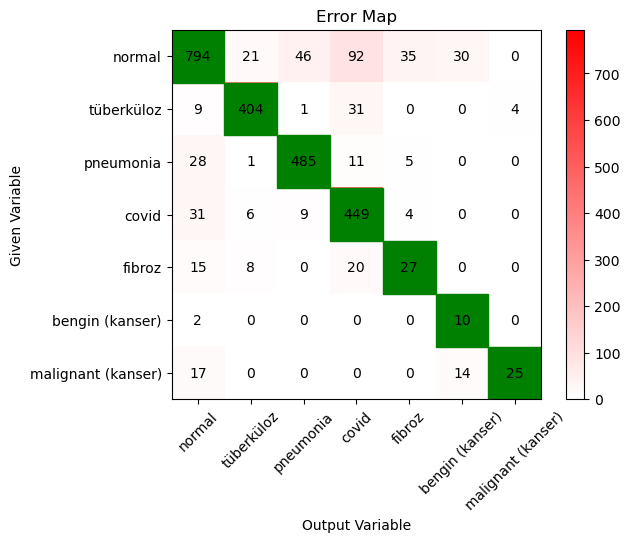

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors

# Example dictionary
"""
data = {
    0: [0, 0, 0, 0, 0, 0],
    1: [0, 0, 0, 0, 0, 0],
    2: [0, 0, 0, 10, 0, 0],
    3: [0, 0, 0, 0, 0, 0],
    4: [0, 0, 0, 0, 0, 0],
    5: [0, 0, 0, 0, 0, 0]
}
"""
row_titles = data_train.get_label_names()#['Row 1', 'Row 2', 'Row 3', 'Row 4', 'Row 5', 'Row 6']
column_titles = data_train.get_label_names()



# Row titles (could be anything you want)
#row_titles = data_train.get_label_names()#['Row 1', 'Row 2', 'Row 3', 'Row 4', 'Row 5', 'Row 6']

# Column titles (could be anything you want)
#column_titles = ['Col 1', 'Col 2', 'Col 3', 'Col 4', 'Col 5', 'Col 6']

# Convert dictionary to a 2D numpy array
matrix = np.array([acc_data[i] for i in range(len(row_titles))])

# Custom colormap for red-white gradient
cmap = mcolors.LinearSegmentedColormap.from_list('red_white', ['white', 'red'])

# Plot using matplotlib
fig, ax = plt.subplots()

# Display the matrix as a heatmap
cax = ax.imshow(matrix, cmap=cmap, interpolation='nearest')

# Add color bar
fig.colorbar(cax)

# Add title for the plot
plt.title('Error Map')

# Set row labels (yticks)
ax.set_yticks(np.arange(len(row_titles)))  # Position of the ticks
ax.set_yticklabels(row_titles)  # Assign the labels to the ticks

# Set column labels (xticks)
ax.set_xticks(np.arange(matrix.shape[1]))  # Position of the ticks
ax.set_xticklabels(column_titles)  # Assign the labels to the ticks

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Add labels to the rows and columns
ax.set_xlabel('Output Variable')
ax.set_ylabel('Given Variable')

# Annotate each cell with the numeric value
for i in range(len(row_titles)):
    for j in range(len(column_titles)):
        # If the row and column index are the same, set color to green
        if i == j:
            ax.text(j, i, str(matrix[i, j]), ha='center', va='center', color='black')
            ax.add_patch(plt.Rectangle((j - 0.5, i - 0.5), 1, 1, color='green'))  # Draw a green square
        else:
            ax.text(j, i, str(matrix[i, j]), ha='center', va='center', color='black')

# Show the plot
plt.show()


In [376]:
plt.savefig(image_stream, format='png')

NameError: name 'image_stream' is not defined

/home/tk/jnotebook/AI/Akciger/Mixed/test/COVID19/COVID19(516).jpg False


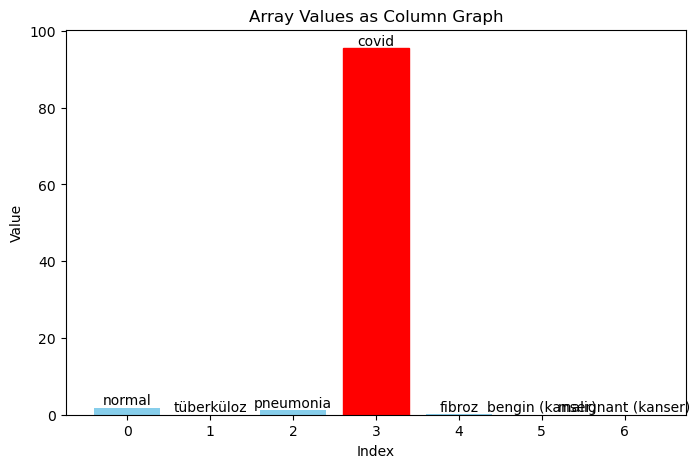

In [46]:
import matplotlib.pyplot as plt

# Sample array (replace with your actual array)
#array = [100, 20, 30, 40, 50, 60, 70]

def plot_array(array):
    # Find the size of the array using len()
    size = len(array)
    
    # Find the highest value and the index of the highest value
    max_value = max(array)
    max_index = array.index(max_value)
    
    # Create a plot
    plt.figure(figsize=(8, 5))
    
    # Plot the array values as a bar graph
    bars = plt.bar(range(size), array, color='skyblue')
    
    # Highlight only the highest column with green
    bars[max_index].set_color('green'if max_index==0 else "red")
    
    # Add a title for the whole graph
    plt.title('Array Values as Column Graph')
    
    # Add labels for each column
    plt.xlabel('Index')
    plt.ylabel('Value')
    
    column_titles = data_train.get_label_names()
    
    # Add a title above each column
    for i in range(size):
        plt.text(bars[i].get_x() + bars[i].get_width() / 2, bars[i].get_height(), 
                 f'{column_titles[i]}', ha='center', va='bottom')
    
    # Display the plot 
    #self.save_plot("plot.png")
    plt.show()
index=1
#input = data_train[index][0].unsqueeze(0)

"""
Labels & Size:
 ~normal:1018 M:1 E:True Start Index:0
 ~tüberküloz:449 M:1 E:True Start Index:1018
 ~pneumonia:530 M:1 E:True Start Index:1467
 ~covid:499 M:1 E:True Start Index:1997
 ~fibroz:70 M:1 E:True Start Index:2496
 ~bengin (kanser):12 M:1 E:True Start Index:2566
 ~malignant (kanser):56 M:1 E:True Start Index:2578
Total Size:2634

"""
plot_array(
    (model( data_test.read_and_transform( data_test.list[3]["data"][0] ).unsqueeze(0) ).to("cpu").squeeze()*100).detach().tolist()
)
#print(data_train[index][1])
#data_train[500][0]
#data_train[500][0].unsqueeze(0)

## Save & Load

In [19]:
# SAVE
import torch

# Assuming 'model' is your trained model
torch.save(model.state_dict(), f'lung_{total_epoch}.pth')
print(f'lung_{total_epoch}.pth" saved')


lung_10.pth" saved


In [17]:
# LOAD

import torch
import torch.nn as nn
import torchvision.models as models

# Load the state_dict from the saved file
model.load_state_dict(torch.load('lung_8.pth'))

# Set the model to evaluation mode (important for inference)
model.eval()

/tmp/ipykernel_3845/702090119.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('lung_8.pth'))


ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [47]:
import pycuda.driver as cuda
cuda.init()
print(cuda.Device(0).compute_capability())


ModuleNotFoundError: No module named 'pycuda'